# Calculating rise/set times with astropy

In [72]:
%matplotlib inline
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
from scipy.optimize import leastsq, fmin_l_bfgs_b
import matplotlib
import matplotlib.pyplot as plt
import datetime
import astropy.units as u
from astropy.coordinates import (EarthLocation, Latitude, 
                                Longitude, get_sun)
from astropy.time import Time
from astropy.coordinates import AltAz

##################################################
# IERS table patch from @eteq ####################
from astropy.utils.data import download_file
from astropy.utils import iers
iers.IERS.iers_table = iers.IERS_A.open(download_file(iers.IERS_A_URL, 
                                                      cache=True))
##################################################

# Some convenience functions

def get_altitude(target, time, location, kwargs={}):
    '''
    Compute altitude of a `target` at a particular time, given
     an observer's `location` (EarthLocation).
    '''
    altaz = target.transform_to(AltAz(target.ra, target.dec, 
                                location=location, obstime=time,
                                **kwargs))
    return altaz.alt

def timebracket(t0, dt, N):
    '''
    Generate `N` times bracketing `t0` going
    backwards and forwards `dt` hours
    
    t0 : datetime.datetime
        Initial time
    dt : float
        Number of hours before and after t0
    N : int
        Number of datetimes in range
    '''
    previous_dt = t0 + np.linspace(-dt, 0, N)*u.hour
    next_dt = t0 + np.linspace(0, dt, N)*u.hour
    return previous_dt, next_dt

def timelinspace(t0, dt, N):
    '''
    Generate `N` linearly spaced times between `t0` 
    and t0+dt where [dt] = day
    
    t0 : datetime.datetime
        Initial time
    dt : float
        Number of days before/after t0. 
        dt < 0 = before, dt > 0 = after
    N : int
        Number of times to generate in range
    '''
    # Keep array in time order
    if dt > 0:
        time_array = t0 + np.linspace(0, dt, N)*u.day
    elif dt < 0:
        time_array = t0 + np.linspace(dt, 0, N)*u.day
    return time_array

def horiz_cross_rising(t, a, horizon=0, unit=u.degree, 
                       return_bounds=False, return_a=False):
    '''
    Find time `t` when values in array `a` go from
    negative to positive (exclude endpoints)
    
    `return_nearest` will return nearest times to zero-crossing
    '''
    condition = (a[:-1] < horizon*unit) * (a[1:] > horizon*unit)
    if sum(condition) < 1:
        return []

    if return_bounds:
        nearest_index = np.argwhere(condition)[0][0]
        
        if a[nearest_index] > horizon*unit:
            lower_bound, upper_bound = t[nearest_index-1], t[nearest_index]
            lower_a, upper_a = a[nearest_index-1].value, a[nearest_index].value
        else:
            lower_bound, upper_bound = t[nearest_index], t[nearest_index+1]
            lower_a, upper_a = a[nearest_index].value, a[nearest_index+1].value
        
        if return_a:
            return (lower_bound, upper_bound), (lower_a, upper_a)
        else:
            return lower_bound, upper_bound
    
    return t[condition][0]

def horiz_cross_setting(t, a, horizon=0, unit=u.degree, return_bounds=False):
    '''
    Find time `t` when values in array `a` go from
    positive to negative (exclude endpoints)
    '''
    condition = (a[:-1] > horizon*unit) * (a[1:] < horizon*unit)
    if sum(condition) < 1:
        return []

    if return_bounds:
        nearest_index = np.argwhere(condition)[0][0]
        
        if a[nearest_index] < horizon*unit:
            lower_bound, upper_bound = t[nearest_index-1], t[nearest_index]
        else:
            lower_bound, upper_bound = t[nearest_index], t[nearest_index+1]
        return lower_bound, upper_bound
    
    return t[condition][0]

def get_rise(time, dt, location, N=1000, return_bounds=False, return_a=False):
    times = timelinspace(time, dt, N)
    sun = get_sun(times)
    altitudes = get_altitude(sun, times, location)
    return horiz_cross_rising(times, altitudes, 
                              return_bounds=return_bounds,
                              return_a=return_a)

# A variety of ways to compute sunrise

def sunrise_doublegrid(time, location, which='nearest', N=300):
    if which == 'nearest' or which == 'next':
        # Calculate next sunrise

        # Do a coarse search with error O(~5 minutes), 
        # return upper/lower bounds
        rise_bounds = get_rise(time, 1, location, N=N, 
                               return_bounds=True)
        
        # Do a fine search with error O(~1 second),
        # return the nearest time to sunrise
        next_rise = get_rise(rise_bounds[0], 
                             (rise_bounds[1] - rise_bounds[0]).value, 
                             location, N=N)
        if which == 'next':
            return next_rise

    if which == 'nearest' or which == 'previous':
        
        # Calculate previous sunrise

        # Do a coarse search with error O(~5 minutes), 
        # return upper/lower bounds
        rise_bounds = get_rise(time, -1, location, N=N, 
                               return_bounds=True)
        
        # Do a fine search with error O(~1 second),
        # return the nearest time to sunrise
        previous_rise = get_rise(rise_bounds[0], 
                                 (rise_bounds[1] - rise_bounds[0]).value, 
                                 location, N=N)
        if which == 'previous':
            return previous_rise
    
    if which == 'nearest':
        if abs(previous_rise - time) < abs(next_rise - time):
            return previous_rise
        else: 
            return next_rise
    raise ValueError, "which can be: 'next', 'previous', 'nearest'"

def two_point_interp(times, altitudes):
    '''
    Draw a straight line between bounding times, find x-intercept.
    '''
    slope = (altitudes[1] - altitudes[0])/(times[1].jd - times[0].jd)
    return Time(times[1].jd - altitudes[1]/slope, format='jd')

def sunrise_dumbinterp(time, location, which='nearest', N=150):
    if which == 'nearest' or which == 'next':
        # Calculate next sunrise

        # Do a coarse search with error O(~7.2 minutes), 
        # return upper/lower bounds, then interpolate between
        # and find x-intercept
        next_rise = two_point_interp(*get_rise(time, 1, location, 
                                               N=N, return_bounds=True, 
                                               return_a=True))

        if False:
            print(t_horizon, rise_bounds[0].jd,rise_bounds[1].jd)
            x_range = np.linspace(rise_bounds[0].jd, rise_bounds[1].jd, 2)
            y_range = slope*x_range + rise_alts[1] - slope*rise_bounds[1].jd
            plt.plot(x_range, y_range)
            plt.plot(x_range, rise_alts,'o')
            plt.axvline(t_horizon)
            plt.axhline(0)
            plt.show()

        if which == 'next':
            return next_rise

    if which == 'nearest' or which == 'previous':
        
        # Calculate previous sunrise

        # Do a coarse search with error O(~5 minutes), 
        # return upper/lower bounds
        rise_bounds = get_rise(time, -1, location, N=N, 
                               return_bounds=True)
        
        # Do a fine search with error O(~1 second),
        # return the nearest time to sunrise
        previous_rise = get_rise(rise_bounds[0], 
                                 (rise_bounds[1] - rise_bounds[0]).value, 
                                 location, N=N)
        if which == 'previous':
            return previous_rise
    
    if which == 'nearest':
        if abs(previous_rise - time) < abs(next_rise - time):
            return previous_rise
        else: 
            return next_rise
    raise ValueError, "which can be: 'next', 'previous', 'nearest'"
    
# Input observer location at Subaru
latitude = '19:49:42.600'
longitude = '-155:28:48.900'
elevation = 0*u.m
location = EarthLocation(lat=latitude, lon=longitude,
                         height=elevation)

time = Time('2015-05-29', 
            location=location, scale='utc')

print(sunrise_dumbinterp(time, location, which='next').iso)

2015-05-29 15:47:08.873


In [73]:
%%timeit
sunrise_doublegrid(time, location)

1 loops, best of 3: 1.27 s per loop


In [74]:
%%timeit
sunrise_dumbinterp(time, location)

1 loops, best of 3: 660 ms per loop


In [78]:
print('doublegrid:\t{}\ninterp:\t\t{}'.format(sunrise_doublegrid(time, location), 
                                              sunrise_dumbinterp(time, location)))

doublegrid:	2015-05-28 15:47:15.874
interp:		2015-05-28 15:47:14.629


### How many altitudes needed to get good linear approx?

In [58]:
timeits = []
times = []
N_range = np.logspace(1, 2.77, 10) #np.arange(100, 1100, 100)
print(N_range)
for N in N_range:
    times.append(sunrise_dumbinterp(time, location, N=N))
    t = %timeit -o sunrise_dumbinterp(time, location, N=N)
    timeits.append(t.best)

[  10.           15.72775251   24.73621992   38.9045145    61.18805758
   96.23506264  151.35612484  238.04916731  374.39783898  588.84365536]
1 loops, best of 3: 431 ms per loop
1 loops, best of 3: 475 ms per loop
1 loops, best of 3: 438 ms per loop
1 loops, best of 3: 459 ms per loop
1 loops, best of 3: 508 ms per loop
1 loops, best of 3: 565 ms per loop
1 loops, best of 3: 671 ms per loop
1 loops, best of 3: 836 ms per loop
1 loops, best of 3: 1.09 s per loop
1 loops, best of 3: 1.48 s per loop


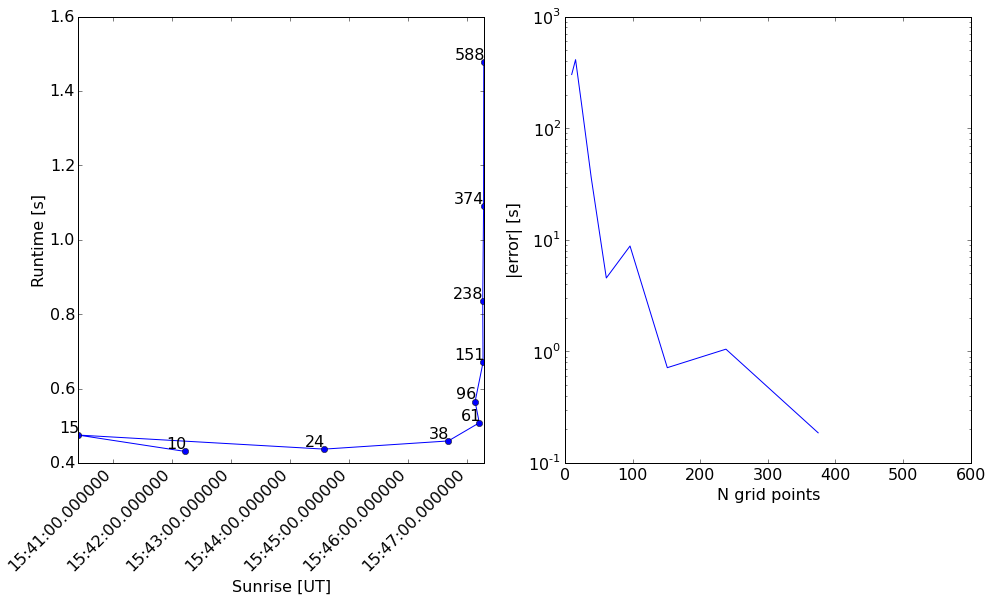

In [71]:
matplotlib.rcParams['font.size'] = 16
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].plot_date(Time(times).plot_date, timeits, '-o')
ax[0].set(xlabel='Sunrise [UT]', ylabel='Runtime [s]')
[l.set(rotation=45, ha='right') for l in ax[0].get_xticklabels()]
for x, y, N_i in zip(Time(times).plot_date, timeits, N_range):
    ax[0].annotate(int(N_i), xy=(x,y), 
                   ha='right', va='bottom')

ax[1].semilogy(N_range, 
               np.abs(24*60*60*(Time(times) - times[-1]).value))
ax[1].set(xlabel='N grid points', ylabel='|error| [s]')
plt.show()